<a href="https://colab.research.google.com/github/jgamel/learn_n_dev/blob/python_modeling_forecasting/Forecast_Avocado_Price_Prophet_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avocado Price Forecasting using Facebook Prophet

### Import Python Packages and Environment Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

%matplotlib inline

###Importing and Analyzing the Avocado CSV

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/input_examples/avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.columns

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')

In [5]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = [d.strftime('%b') for d in df.Date]
df['month'] = df['month'].replace({'01': 'January', '02': 'February', '03': 'March', 
                                   '04': 'April', '05': 'May', '06': 'June', 
                                   '07': 'July', '08': 'August', '09': 'September', 
                                   '10': 'October', '11': 'November', 
                                   '12': 'December'})
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,Dec
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,Dec
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,Dec
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,Dec
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,Nov


###Data Visualizations

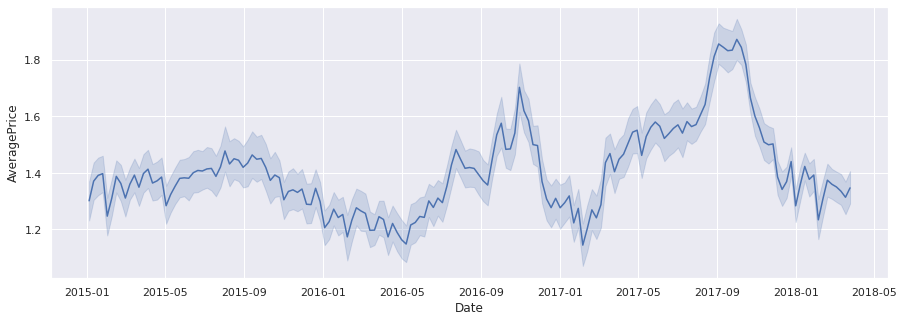

In [6]:
sns.set(rc = {'figure.figsize': (15, 5)})
sns.lineplot(x = "Date", y = "AveragePrice", data = df)

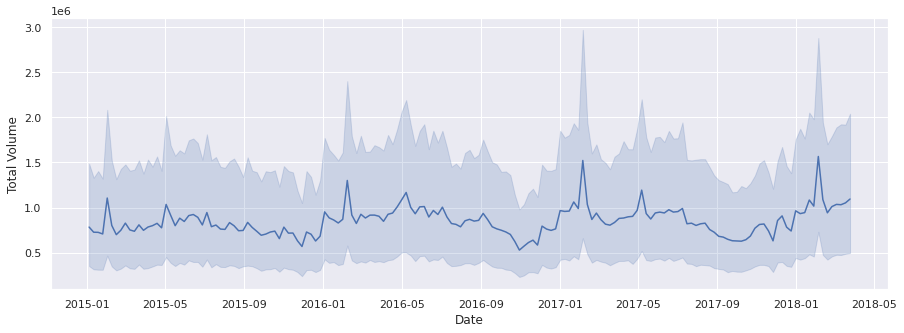

In [7]:
sns.lineplot(x = "Date", y = "Total Volume", data = df)

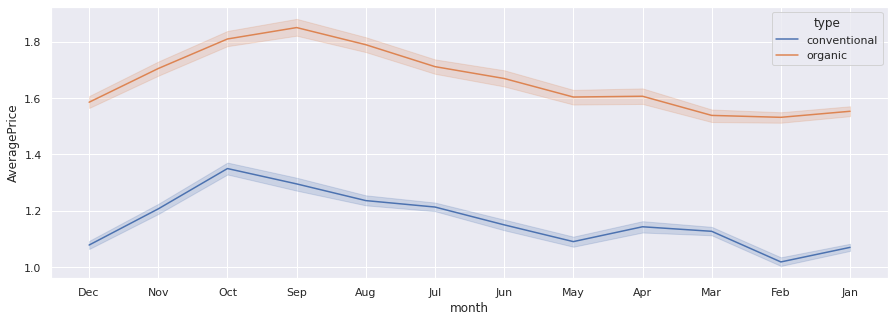

In [8]:
sns.set(rc = {'figure.figsize': (15, 5)})
sns.lineplot(x="month", y="AveragePrice", hue='type', data=df)

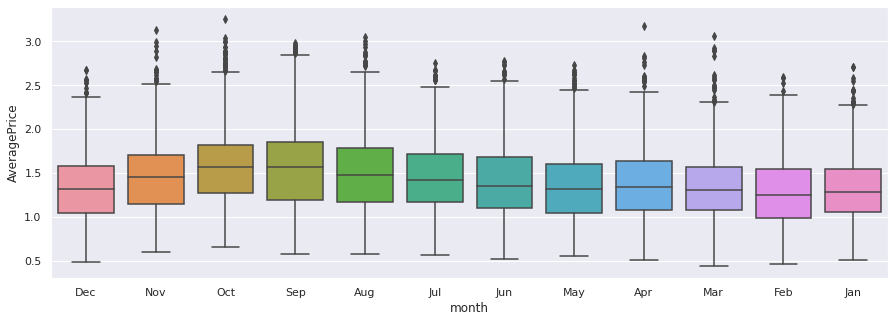

In [9]:
sns.boxplot(x='month',y='AveragePrice',data=df)

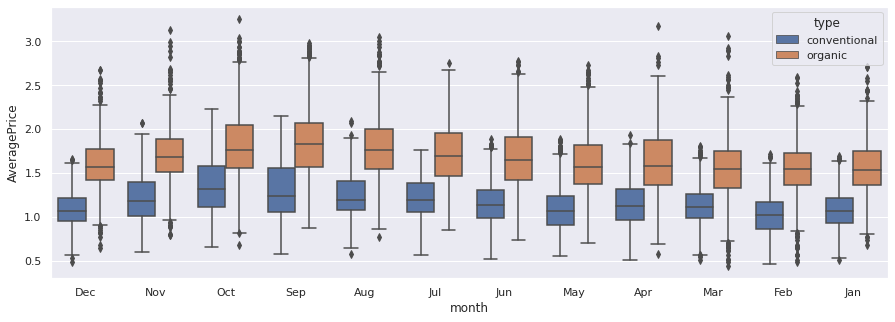

In [10]:
sns.boxplot(x='month',y='AveragePrice',hue='type',data=df)

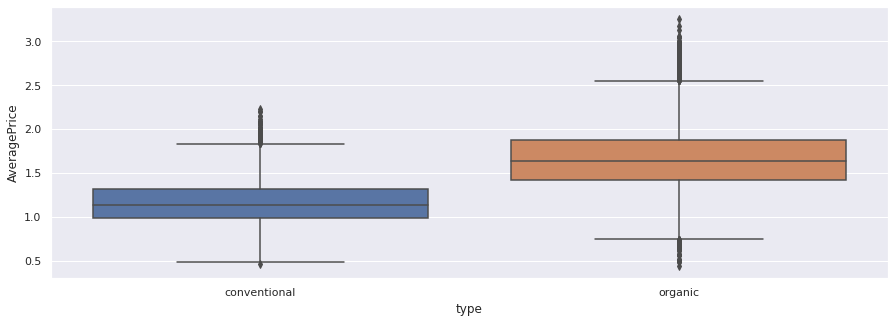

In [11]:
sns.boxplot(x="type", y="AveragePrice", data=df)

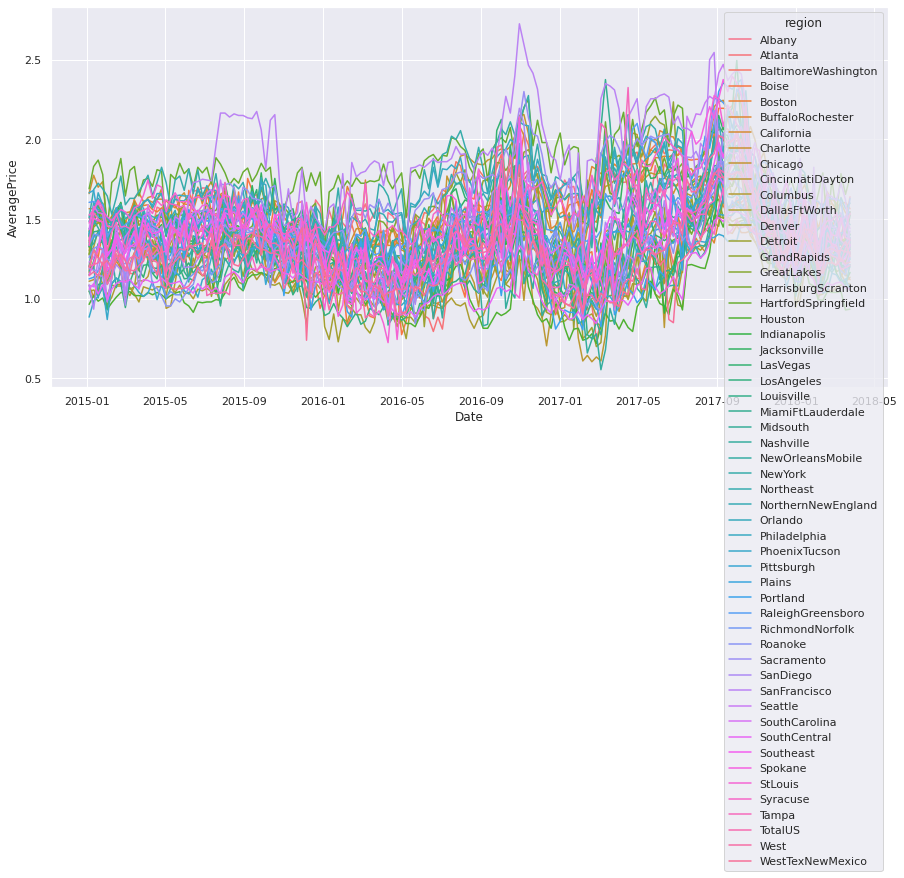

In [12]:
sns.set(rc = {'figure.figsize': (15, 7)})
sns.lineplot(x="Date", y="AveragePrice", hue='region', data=df, ci = None)

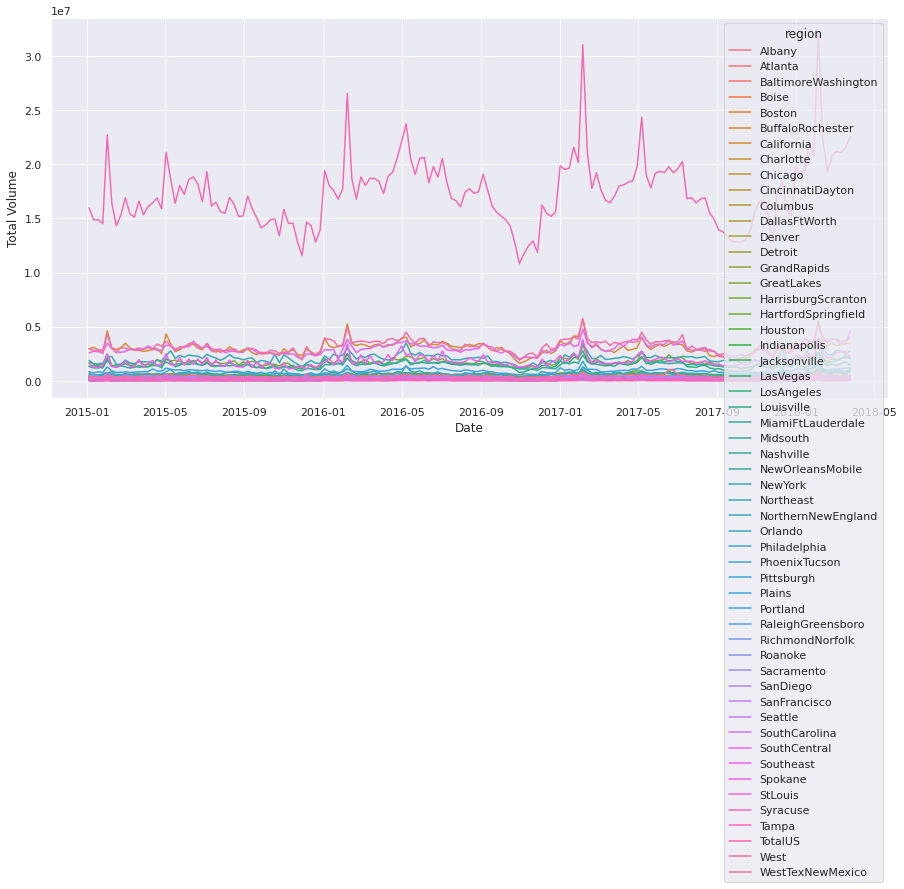

In [13]:
sns.lineplot(x="Date", y="Total Volume", hue='region', data=df, ci = None)

###Region-wise Data Analysis

In [14]:
df.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [15]:
df.region.nunique()

54

In [16]:
region_df = df.groupby(['region']).agg({'Total Bags': 'sum', 
                                        'Large Bags': 'sum', 
                                        'XLarge Bags': 'sum', 
                                        'Small Bags': 'sum',
                                        'Total Volume': 'sum'})

region_df['Total Bags'] = region_df['Total Bags'].astype('int64') 
region_df['Large Bags'] = region_df['Large Bags'].astype('int64') 
region_df['XLarge Bags'] = region_df['XLarge Bags'].astype('int64') 
region_df['Small Bags'] = region_df['Small Bags'].astype('int64') 
region_df['Total Volume'] = region_df['Total Volume'].astype('int64') 
region_df.head(10)

,Total Bags,Large Bags,XLarge Bags,Small Bags,Total Volume
region,,,,,
Albany,2680254,389881,43429,2246944,16067799
Atlanta,28560513,10839675,278101,17442735,88605118
BaltimoreWashington,35306146,981546,206985,34117612,134713919
Boise,5399412,711028,10449,4677932,14413187
Boston,21495476,1500167,84879,19910427,97273984
BuffaloRochester,11610751,1260418,81901,10268431,22962470
California,246682193,12311935,5272577,229097679,1028981653
Charlotte,11697942,984487,69603,10643851,35555544
Chicago,16865400,1691874,378872,14794653,133702338


In [17]:
region_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, Albany to WestTexNewMexico
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Total Bags    54 non-null     int64
 1   Large Bags    54 non-null     int64
 2   XLarge Bags   54 non-null     int64
 3   Small Bags    54 non-null     int64
 4   Total Volume  54 non-null     int64
dtypes: int64(5)
memory usage: 2.5+ KB


###Forcasting Average Price for the next year using Facebook Prophet

In [18]:
data = df[['AveragePrice', 'Date']].copy()
data.rename(columns={'Date':'ds','AveragePrice' : 'y'}, inplace=True)
data.sort_values('ds', inplace = True)
data.head()

,y,ds
11569,1.75,2015-01-04
9593,1.49,2015-01-04
10009,1.68,2015-01-04
1819,1.52,2015-01-04
9333,1.64,2015-01-04


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 11569 to 8814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       18249 non-null  float64       
 1   ds      18249 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 427.7 KB


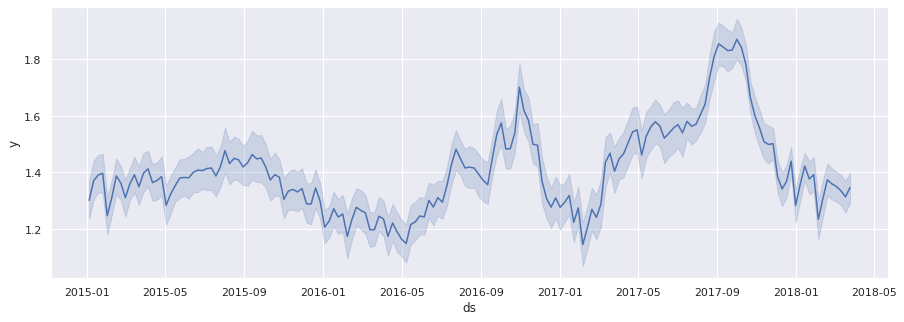

In [20]:
sns.set(rc = {'figure.figsize': (15, 5)})
sns.lineplot(x="ds", y="y", data=data)

In [21]:
data.ds.max()

Timestamp('2018-03-25 00:00:00')

In [22]:
m = Prophet()
m.fit(data)

# forecasting the price of avocados for the next year for all regions.
future = m.make_future_dataframe(periods = 365) 
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


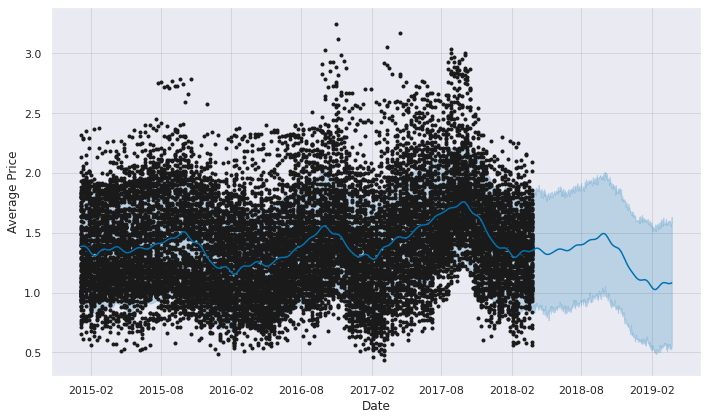

In [23]:
figure = m.plot(forecast, xlabel='Date', ylabel='Average Price')

### Forcasting Total Volume for the next year using Facebook Prophet

In [34]:
data = df[['Total Volume', 'Date']].copy()
data.rename(columns={'Date':'ds','Total Volume' : 'y'}, inplace=True)
data.sort_values('ds', inplace = True)
data.head()

,y,ds
11569,27365.89,2015-01-04
9593,17723.17,2015-01-04
10009,2896.72,2015-01-04
1819,54956.80,2015-01-04
9333,1505.12,2015-01-04


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 11569 to 8814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       18249 non-null  float64       
 1   ds      18249 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 427.7 KB


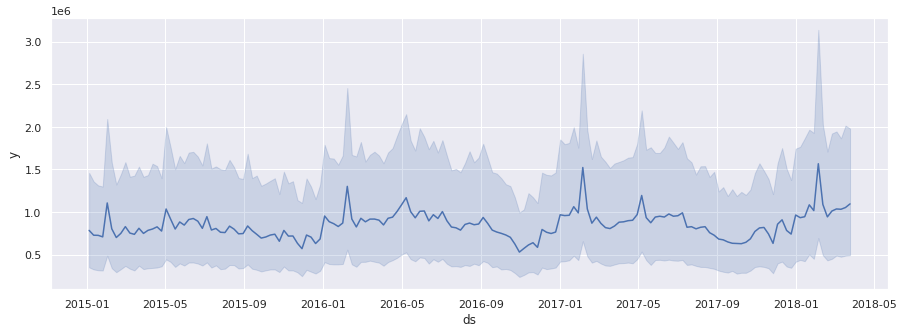

In [36]:
sns.set(rc = {'figure.figsize': (15, 5)})
sns.lineplot(x="ds", y="y", data=data)

In [41]:
m = Prophet()
m.fit(data)

# forecasting the Total Volume of avocados for the next year for all regions.
future = m.make_future_dataframe(periods = 365) 
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


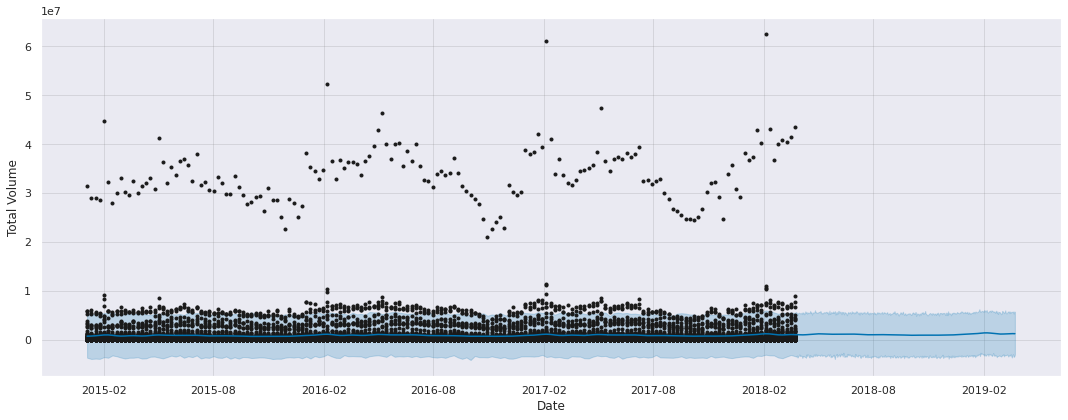

In [42]:
figure = m.plot(forecast, xlabel='Date', ylabel='Total Volume', figsize=(15, 6))

###Forcasting Total Bags for the next year using Facebook Prophet

In [29]:
data = df[['Total Bags', 'Date']].copy()
data.rename(columns={'Date':'ds','Total Bags' : 'y'}, inplace=True)
data.sort_values('ds', inplace = True)
data.head()

,y,ds
11569,13598.46,2015-01-04
9593,905.55,2015-01-04
10009,2528.08,2015-01-04
1819,14925.18,2015-01-04
9333,374.35,2015-01-04


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 11569 to 8814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       18249 non-null  float64       
 1   ds      18249 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 427.7 KB


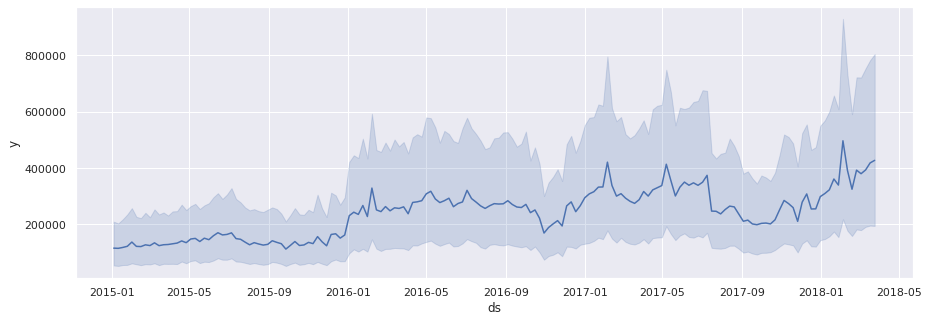

In [31]:
sns.set(rc = {'figure.figsize': (15, 5)})
sns.lineplot(x="ds", y="y", data=data)

In [32]:
m = Prophet()
m.fit(data)

# forecasting the Total Bags of avocados for the next year for all regions.
future = m.make_future_dataframe(periods = 365) 
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


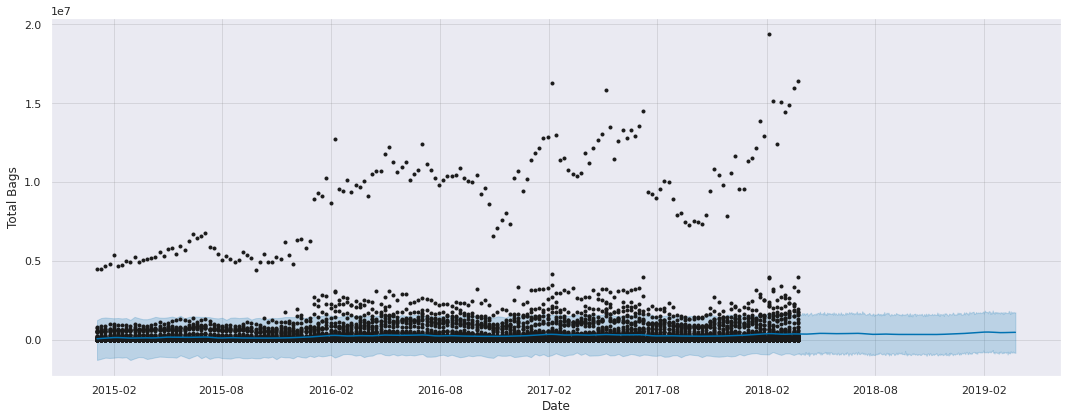

In [33]:
figure = m.plot(forecast, xlabel='Date', ylabel='Total Bags', figsize=(15, 6))